# Predicting Road Accident Risk 
 **Goal:** Build a model that predicts risk of accidents (a numeric likelihood) given features in `train.csv`.  
 **Model choice (this notebook):** LightGBM gradient boosting (fast, robust for tabular data).

 Notes:

- Run in Kaggle Notebook environment (or local env with pandas, numpy, lightgbm, scikit-learn installed).
- The notebook uses K-Fold cross-validation and outputs a `submission.csv` compatible with the competition.

Sources: Kaggle competition page and community baselines inspired the lightgbm approach. :contentReference[oaicite:1]{index=1}

This notebook:
- Loads data
- Explores basic distributions and relationships (plots + boxplots for outliers)
- Preprocesses and encodes features
- Trains LightGBM with K-Fold CV
- Evaluates with RMSE/MAE and plots feature importance
- Prepares submission




# **Import Libraries:**

In [7]:
# 1. Imports and basic settings

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# Print python packages versions (helpful for reproducibility)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("lightgbm:", lgb.__version__)

pandas: 2.2.3
numpy: 1.26.4
lightgbm: 4.6.0


# **Load & Read the Dataset:**

In [8]:
DATA_DIR = Path("/kaggle/input/playground-series-s5e10")  # change if running elsewhere
if not DATA_DIR.exists():
    # fallback to current dir - user may have files locally
    DATA_DIR = Path(".")

train_path = DATA_DIR / "train.csv"
test_path = DATA_DIR / "test.csv"
sample_sub_path = DATA_DIR / "sample_submission.csv"


In [9]:
# read
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(sample_sub_path)

print("train shape:", train.shape)
print("test shape:", test.shape)
print("sample_submission shape:", sample_submission.shape)


train shape: (517754, 14)
test shape: (172585, 13)
sample_submission shape: (172585, 2)


In [10]:
# show head
display(train.head())


,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [11]:
display(test.head())

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
0,517754,highway,2,0.34,45,night,clear,True,True,afternoon,True,True,1
1,517755,urban,3,0.04,45,dim,foggy,True,False,afternoon,True,False,0
2,517756,urban,2,0.59,35,dim,clear,True,False,afternoon,True,True,1
3,517757,rural,4,0.95,35,daylight,rainy,False,False,afternoon,False,False,2
4,517758,highway,2,0.86,35,daylight,clear,True,False,evening,False,True,3


# **Quick look at columns**
Columns given by the problem:
- id, road_type, num_lanes, curvature, speed_limit, lighting, weather, road_signs_present, public_road, time_of_day, holiday, school_season, num_reported_accidents (target)


In [12]:
# 3. Basic info & missing values
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

None

In [13]:
display(train.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,517754.0,NaN,NaN,NaN,258876.5,149462.849974,0.0,129438.25,258876.5,388314.75,517753.0
road_type,517754,3,highway,173672,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_lanes,517754.0,NaN,NaN,NaN,2.491511,1.120434,1.0,1.0,2.0,3.0,4.0
curvature,517754.0,NaN,NaN,NaN,0.488719,0.272563,0.0,0.26,0.51,0.71,1.0
speed_limit,517754.0,NaN,NaN,NaN,46.112575,15.788521,25.0,35.0,45.0,60.0,70.0
lighting,517754,3,dim,183826,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weather,517754,3,foggy,181463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
road_signs_present,517754,2,False,259289,NaN,NaN,NaN,NaN,NaN,NaN,NaN
public_road,517754,2,True,260045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_of_day,517754,3,morning,173410,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
print("Missing values (train):")
print(train.isna().sum())

Missing values (train):
id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


In [15]:
print("\nUnique values per column (train):")
print(train.nunique())


Unique values per column (train):
id                        517754
road_type                      3
num_lanes                      4
curvature                    261
speed_limit                    5
lighting                       3
weather                        3
road_signs_present             2
public_road                    2
time_of_day                    3
holiday                        2
school_season                  2
num_reported_accidents         8
accident_risk                 98
dtype: int64


# **EDA — distributions, relationships, and outlier boxplots**
We will:
- Plot distributions of the numeric features and target
- Countplots for categorical features
- Boxplots to inspect outliers for numeric features (curvature, speed_limit, num_reported_accidents etc.)


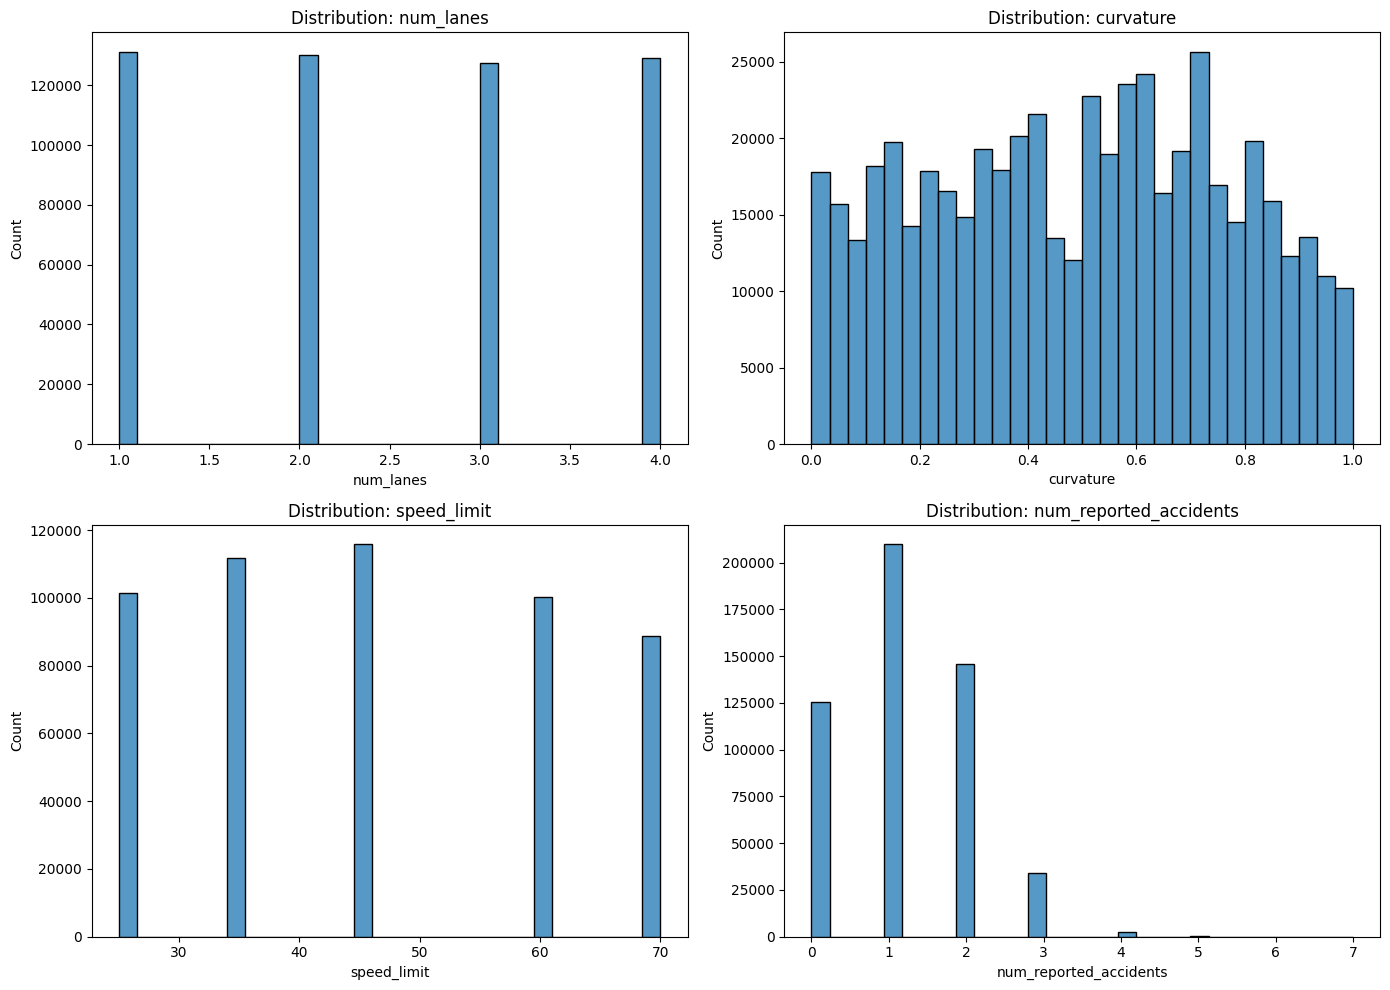

In [16]:
# 4a. Numeric histograms
numeric_cols = ["num_lanes", "curvature", "speed_limit", "num_reported_accidents"]
plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train[col], kde=False, bins=30)
    plt.title(f"Distribution: {col}")
plt.tight_layout()
plt.show()


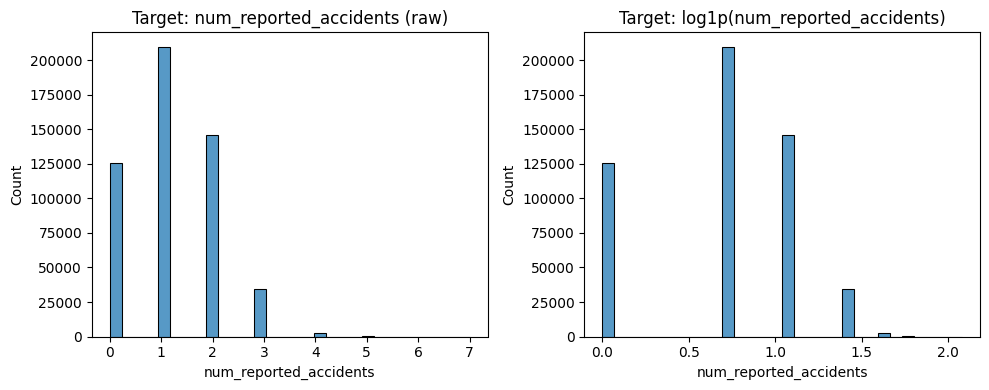

In [17]:
# 4b. Target distribution and log transform check
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(train["num_reported_accidents"], bins=30, kde=False)
plt.title("Target: num_reported_accidents (raw)")

plt.subplot(1,2,2)
sns.histplot(np.log1p(train["num_reported_accidents"]), bins=30, kde=False)
plt.title("Target: log1p(num_reported_accidents)")
plt.tight_layout()
plt.show()


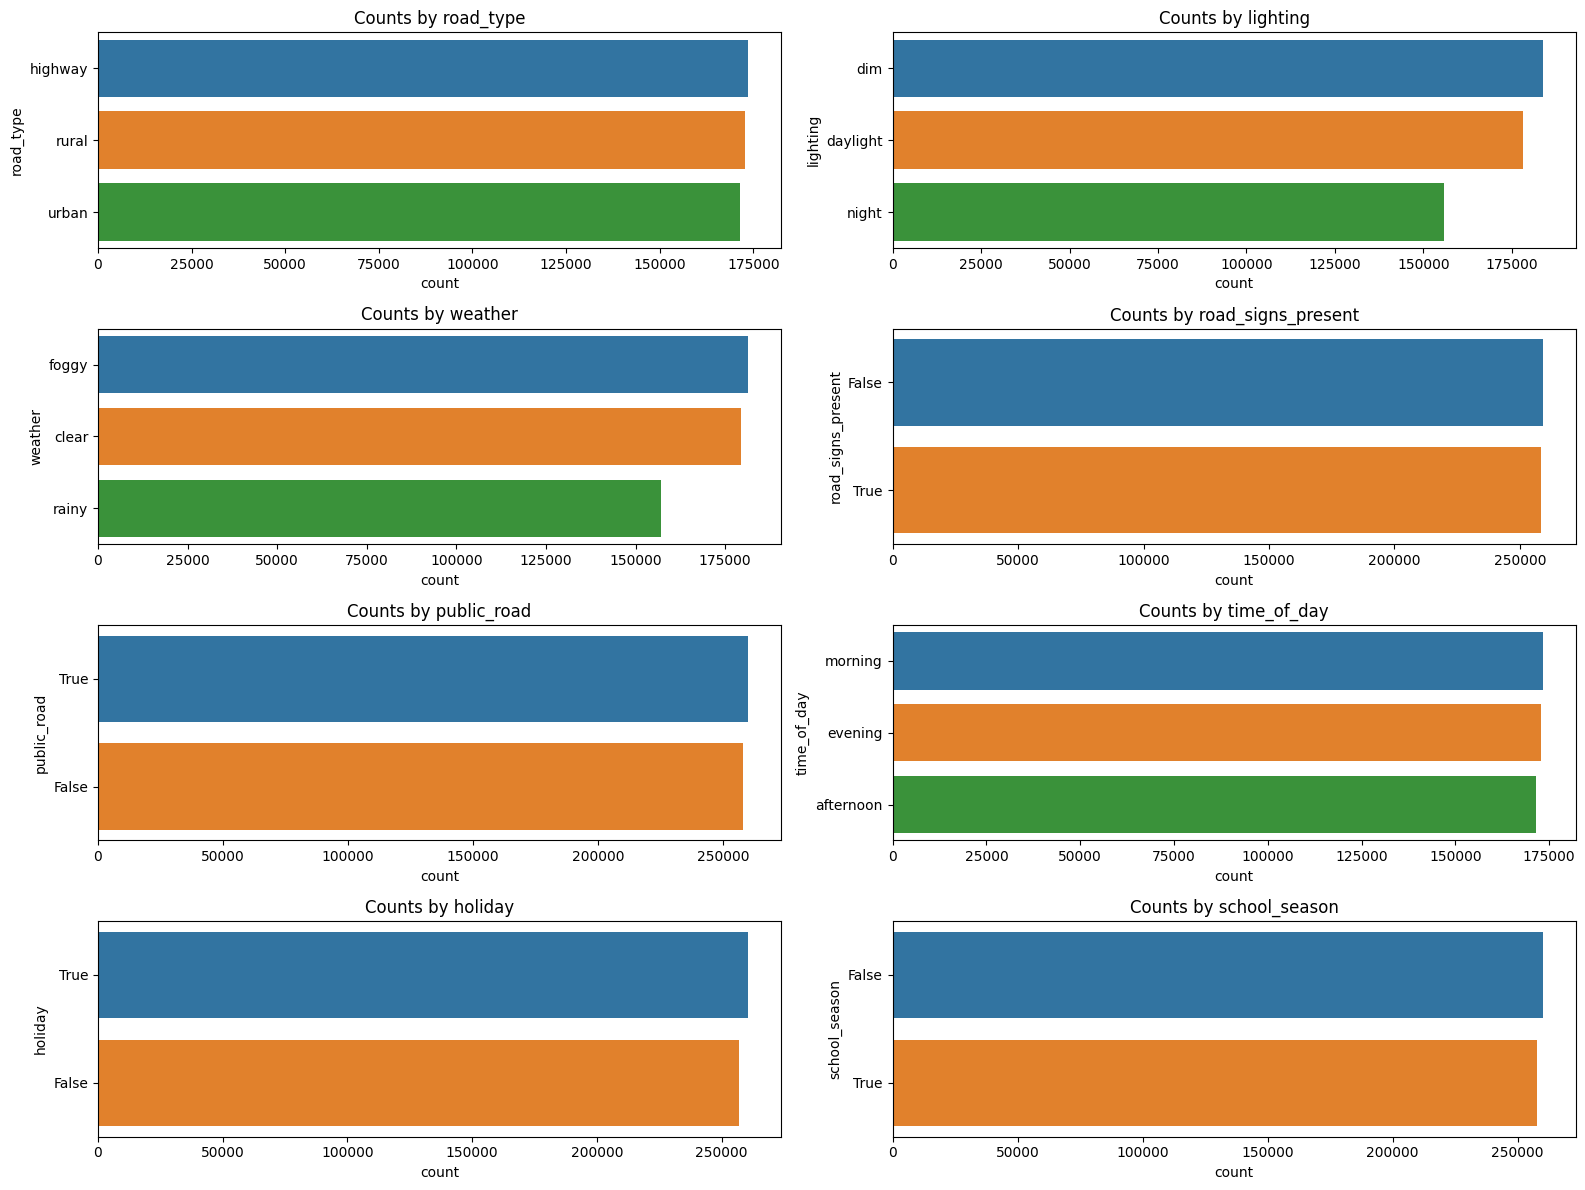

In [18]:
# 4c. Categorical countplots
cat_cols = ["road_type", "lighting", "weather", "road_signs_present", "public_road", "time_of_day", "holiday", "school_season"]
plt.figure(figsize=(16, 12))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 2, i)
    sns.countplot(y=col, data=train, order=train[col].value_counts().index)
    plt.title(f"Counts by {col}")
plt.tight_layout()
plt.show()


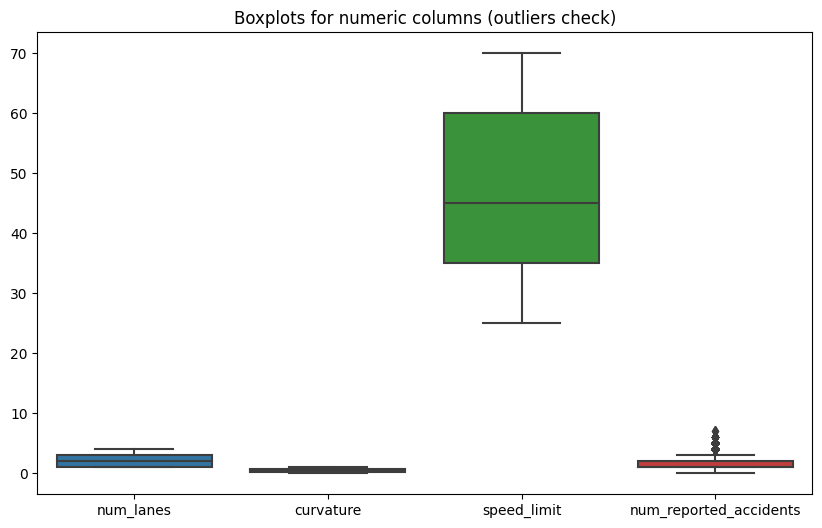

In [19]:
# 4d. Boxplots for numeric features to inspect outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=train[numeric_cols])
plt.title("Boxplots for numeric columns (outliers check)")
plt.show()


# ** Feature engineering & preprocessing**
 - Encode categorical features (LabelEncoder for LightGBM categorical support)
 - Create some simple engineered features if helpful (e.g., lanes_per_speed, is_high_speed)

In [20]:

train2 = train.copy()
test2  = test.copy()

# Example engineered features:
def add_features(df):
    df["lanes_over_speed"] = df["num_lanes"] / (df["speed_limit"] + 1e-6)
    df["curvature_over_lanes"] = df["curvature"] / (df["num_lanes"] + 1e-6)
    df["is_high_speed"] = (df["speed_limit"] >= 80).astype(int)  # adjust threshold per dataset
    return df

train2 = add_features(train2)
test2  = add_features(test2)

# List of features to use
feature_cols = [
    "road_type","num_lanes","curvature","speed_limit","lighting","weather",
    "road_signs_present","public_road","time_of_day","holiday","school_season",
    "lanes_over_speed","curvature_over_lanes","is_high_speed"
]

# Label encode categorical columns (LightGBM accepts categorical_feature indices if integers)
categorical_cols = ["road_type","lighting","weather","road_signs_present","public_road","time_of_day","holiday","school_season"]
lbl_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    # fit on combined to avoid unseen labels in test
    combined = pd.concat([train2[col], test2[col]], axis=0).astype(str)
    le.fit(combined)
    train2[col] = le.transform(train2[col].astype(str))
    test2[col]  = le.transform(test2[col].astype(str))
    lbl_encoders[col] = le

# Confirm features
print("Features used:", feature_cols)
train2[feature_cols].head()


Features used: ['road_type', 'num_lanes', 'curvature', 'speed_limit', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'lanes_over_speed', 'curvature_over_lanes', 'is_high_speed']


,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,lanes_over_speed,curvature_over_lanes,is_high_speed
0,2,2,0.06,35,0,2,0,1,0,0,1,0.057143,0.030000,0
1,2,4,0.99,35,0,0,1,0,1,1,1,0.114286,0.247500,0
2,1,4,0.63,70,1,0,0,1,2,1,0,0.057143,0.157500,0
3,0,4,0.07,35,1,2,1,1,2,0,0,0.114286,0.017500,0
4,1,1,0.58,60,0,1,0,0,1,1,0,0.016667,0.579999,0


#  **Prepare target and define CV**
We will:
- Use log1p on the target to stabilize variance if skewed.
- Use K-Fold CV (K=5) since this is not a classification with class imbalance; if there were temporal or grouped aspects we'd adjust.


In [21]:
# Target transform
y = train2["num_reported_accidents"].values
y_log = np.log1p(y)  # model on log scale

X = train2[feature_cols].copy()
X_test = test2[feature_cols].copy()


# **LightGBM training with K-Fold CV**

In [23]:
#  LightGBM training loop (compatible with latest LightGBM)
NFOLD = 5
kf = KFold(n_splits=NFOLD, shuffle=True, random_state=RANDOM_STATE)

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(X_test))
feature_importance_df = pd.DataFrame()
rmse_scores = []
mae_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y_log), 1):
    print(f"\nFold {fold}")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y_log[train_idx], y_log[val_idx]
    
    lgb_train = lgb.Dataset(
        X_train, y_train,
        categorical_feature=[X.columns.get_loc(c) for c in categorical_cols if c in X.columns]
    )
    lgb_val = lgb.Dataset(
        X_val, y_val, reference=lgb_train,
        categorical_feature=[X.columns.get_loc(c) for c in categorical_cols if c in X.columns]
    )
    
    #  Use callbacks for early stopping and logging
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=5000,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=200)
        ]
    )
    
    # Predict
    val_pred_log = model.predict(X_val, num_iteration=model.best_iteration)
    oof_preds[val_idx] = val_pred_log
    test_pred_log = model.predict(X_test, num_iteration=model.best_iteration)
    test_preds += test_pred_log / NFOLD
    
    # Metrics on original scale
    val_pred = np.expm1(val_pred_log)
    val_true = np.expm1(y_val)
    rmse = mean_squared_error(val_true, val_pred, squared=False)
    mae = mean_absolute_error(val_true, val_pred)
    print(f"Fold {fold} RMSE: {rmse:.5f}  MAE: {mae:.5f}")
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    
    # Feature importance
    fold_imp = pd.DataFrame()
    fold_imp["feature"] = X.columns
    fold_imp["importance"] = model.feature_importance(importance_type="gain")
    fold_imp["fold"] = fold
    feature_importance_df = pd.concat([feature_importance_df, fold_imp], axis=0)
    
print("\nCV RMSE mean:", np.mean(rmse_scores), "std:", np.std(rmse_scores))
print("CV MAE mean:", np.mean(mae_scores), "std:", np.std(mae_scores))







Fold 1
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.435302	valid's rmse: 0.435487
Early stopping, best iteration is:
[241]	train's rmse: 0.435069	valid's rmse: 0.435477
Fold 1 RMSE: 0.87962  MAE: 0.68220

Fold 2
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.434887	valid's rmse: 0.437229
Early stopping, best iteration is:
[240]	train's rmse: 0.434665	valid's rmse: 0.437195
Fold 2 RMSE: 0.88102  MAE: 0.68539

Fold 3
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.435248	valid's rmse: 0.435782
[400]	train's rmse: 0.434257	valid's rmse: 0.435786
Early stopping, best iteration is:
[305]	train's rmse: 0.43468	valid's rmse: 0.435753
Fold 3 RMSE: 0.88145  MAE: 0.68362

Fold 4
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.435067	valid's rmse: 0.436366
[400]	train's rmse: 0.434113	valid's rmse: 0.436345
Early stopping, best iteration is:
[305]	tr

In [24]:
oof_preds_orig = np.expm1(oof_preds)
rmse_oof = mean_squared_error(train2["num_reported_accidents"], oof_preds_orig, squared=False)
mae_oof = mean_absolute_error(train2["num_reported_accidents"], oof_preds_orig)
print("OOF RMSE:", rmse_oof)
print("OOF MAE :", mae_oof)


OOF RMSE: 0.8805959225716232
OOF MAE : 0.6837138221110943


# **Feature plot**


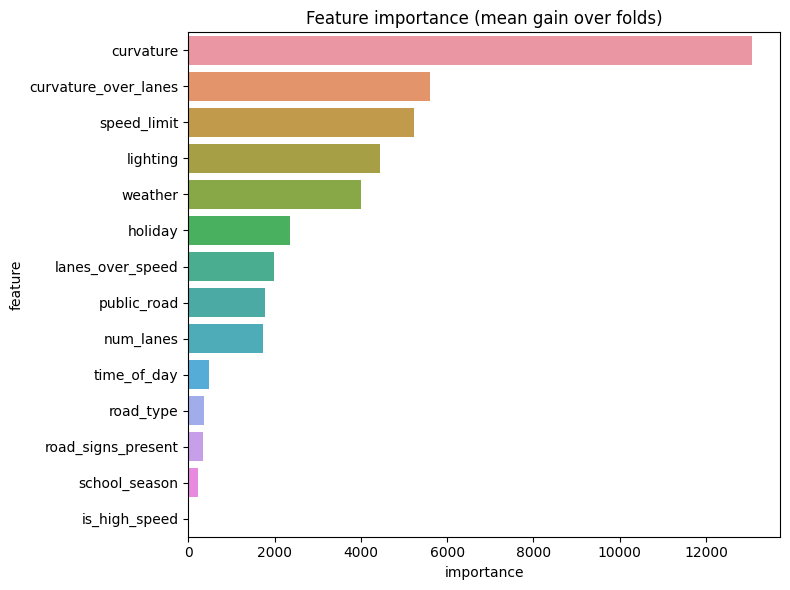

In [25]:
# Aggregate feature importance
imp_mean = feature_importance_df.groupby("feature")["importance"].mean().sort_values(ascending=False).reset_index()
plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=imp_mean)
plt.title("Feature importance (mean gain over folds)")
plt.tight_layout()
plt.show()


# **Inspect predictions distribution and any suspicious extreme predictions**


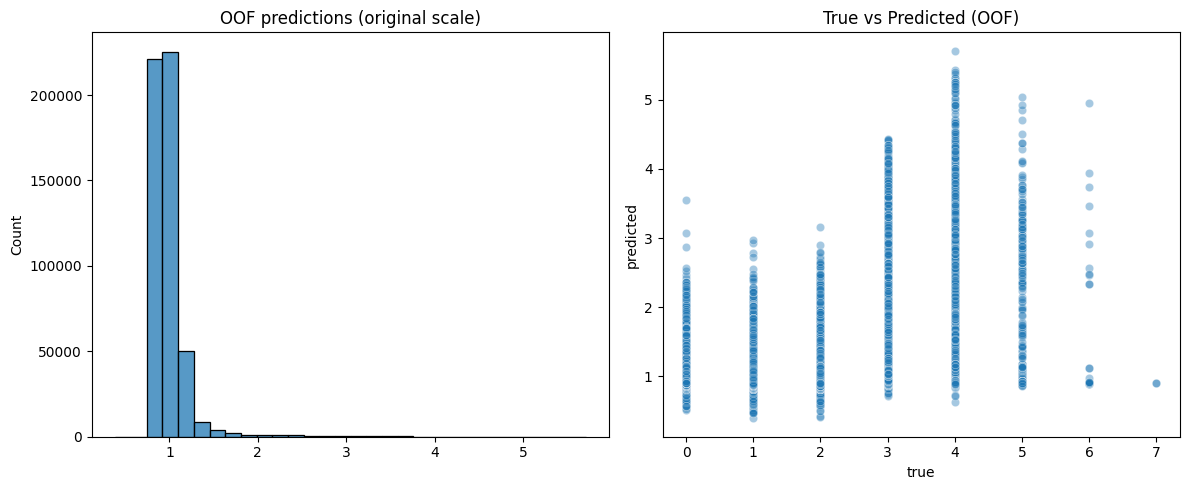

In [26]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(oof_preds_orig, bins=30, kde=False)
plt.title("OOF predictions (original scale)")

plt.subplot(1,2,2)
sns.scatterplot(x=train2["num_reported_accidents"], y=oof_preds_orig, alpha=0.4)
plt.xlabel("true")
plt.ylabel("predicted")
plt.title("True vs Predicted (OOF)")
plt.tight_layout()
plt.show()


#  **Prepare submission**
- `sample_submission`  has columns: id and num_reported_accidents (or target). We'll put our predictions and save a CSV.


In [27]:
# Revert test predictions
test_preds_orig = np.expm1(test_preds)

# Construct submission DataFrame
sub = sample_submission.copy()
# Inspect sample_submission columns to find the target column name
print("Sample submission columns:", sub.columns.tolist())

# Choose the likely target column name (if sample uses 'num_reported_accidents', else adjust)
target_col = [c for c in sub.columns if c != "id"][0]  # first non-id col
sub[target_col] = test_preds_orig
# Ensure no negative predictions (just in case) and round if required
sub[target_col] = sub[target_col].clip(lower=0)
sub[target_col] = sub[target_col].round(6)

# Save
submission_path = "submission.csv"
sub.to_csv(submission_path, index=False)
print("Saved submission to", submission_path)
sub.head()


Sample submission columns: ['id', 'accident_risk']
Saved submission to submission.csv


,id,accident_risk
0,517754,0.885671
1,517755,0.906832
2,517756,0.896343
3,517757,1.730436
4,517758,0.971577


# **Notes and improvements**
- **Model**: LightGBM baseline. Consider CatBoost for native categorical support without label encoding.
- **Feature engineering**: Add interactions, cyclical encoding for time_of_day if it is numeric (sin/cos), distance-related features if coordinates available, or aggregated statistics if group keys exist.
- **Target**: If target is heavily zero-inflated, consider a two-stage model (classification of zero vs non-zero + regression) or Poisson/negative-binomial model.
- **Hyperparameter tuning**: Use Optuna to tune `num_leaves`, `min_child_samples`, `learning_rate`, etc.
- **Ensembling**: Blend LightGBM + CatBoost + XGBoost or simple stacking for robustness.
- **Calibration**: Check calibration if you want probabilistic estimates.
